In [5]:
import os
import yaml

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
sns.set_context("paper")
sns.set_palette("colorblind")

In [7]:
def get_all_file_paths(directory, contains=None):
    file_paths = []  # List to store all file paths
    for root, _, files in os.walk(directory):
        for file in files:
            # Create full path by joining root and file
            if(contains is not None):
                if contains in file:
                    file_paths.append(os.path.join(root, file))
            else:
                file_paths.append(os.path.join(root, file))
    return file_paths

In [8]:
def get_timestamp(string: str):
    return string.split('_')[-1].split('.')[0]

In [9]:
def reshape_data(df: pd.DataFrame):
    df['loss'] = df['loss'].replace('CE Loss', 'CE Loss')
    df['loss'] = df['loss'].replace('CE and MSE Loss', 'CE Loss + NTL-MSE')
    df['loss'] = df['loss'].replace('CE and Wassserstein Loss', 'CE Loss + NTL-WAS-CDF')
    df['loss'] = df['loss'].replace('CE and Abs Diff NTL Loss', 'CE Loss + NTL-WAS')

    df.rename(columns={'loss': 'Loss'}, inplace=True)
    df.rename(columns={'standalone': 'Standalone'}, inplace=True)
    df.rename(columns={'forward pass': 'Forward pass'}, inplace=True)
    df.rename(columns={'training step': 'Training step'}, inplace=True)

    df_long = df.melt(id_vars="Loss", var_name="benchmark", value_name="time")
    df_long["mean_time"] = df_long["time"].apply(lambda x: x.split(",")[0][1:]).astype(float)
    df_long["error"] = df_long["time"].apply(lambda x: x.split(",")[1][1:-1]).astype(float)
    del df_long["time"]
    return df_long

In [10]:
def get_df_by_number_share(directory):
    file_paths = get_all_file_paths(directory, contains='.csv')
    dfs = {}

    for file_path in file_paths:
        print(file_path)
        timestamp = get_timestamp(file_path)
        config_file = get_all_file_paths(directory, contains = timestamp + '.stored_yaml')[0]
        with open(config_file, 'r') as file:
            config = yaml.load(file, Loader=yaml.FullLoader)
        number_share = config['forward pass benchmark']['number_share']
        dfs[number_share] = reshape_data(pd.read_csv(file_path))

    dfs = dict(sorted(dfs.items()))

    return dfs


In [11]:
dfs = get_df_by_number_share('gpu/')

gpu/benchmark_results_173445291367.csv
gpu/benchmark_results_173445756144.csv
gpu/benchmark_results_173446236707.csv
gpu/benchmark_results_173445994530.csv
gpu/benchmark_results_173444868654.csv
gpu/benchmark_results_173446479231.csv
gpu/benchmark_results_173446724990.csv
gpu/benchmark_results_173446993997.csv
gpu/benchmark_results_173444686296.csv
gpu/benchmark_results_173445072449.csv
gpu/benchmark_results_173445519354.csv


In [12]:
dfs[0.1].head()

,Loss,benchmark,mean_time,error
0,CE Loss,Standalone,0.013425,0.000006
1,CE Loss + NTL-MSE,Standalone,0.013855,0.000011
2,CE Loss + NTL-WAS-CDF,Standalone,0.047136,0.000020
3,CE Loss + NTL-WAS,Standalone,0.013710,0.000009
4,CE Loss,Forward pass,0.219285,0.009646


In [45]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def combined_plots(df):
    # Set Seaborn style for publication-ready visuals
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

    # Unique benchmarks and loss functions
    benchmarks = df["benchmark"].unique()
    loss_functions = df["Loss"].unique()

    # Define colors using Seaborn palette
    palette = sns.color_palette("deep")
    color_map = {loss: color for loss, color in zip(loss_functions, palette)}

    # Set up the plot with one subplot per benchmark
    fig, axes = plt.subplots(1, len(benchmarks), figsize=(5 * len(benchmarks), 6), sharey=True)

    # Calculate the overall tallest bar for consistent buffer across all subplots
    max_runtime = (df["mean_time"] + df["error"]).max() * 1_000

    # Plot for each benchmark
    for i, (benchmark, ax) in enumerate(zip(benchmarks, axes)):
        subset = df[df["benchmark"] == benchmark]
        
        # Bar positions
        x_positions = np.arange(len(subset))
        
        # Plot bars with error bars, using different colors for each loss function
        for j, (loss, mean_time, error) in enumerate(zip(subset["Loss"], subset["mean_time"], subset["error"])):
            ax.bar(x_positions[j], mean_time * 1_000,  # Scale mean_time to ms
                   yerr=error * 1_000,  # Scale error to ms
                   capsize=5, color=color_map[loss], alpha=0.8, label=loss if i == 0 else "")

        # Customize each subplot
        ax.set_xticks(x_positions)
        ax.set_xticklabels(subset["Loss"], rotation=45, ha="right", fontsize=12)
        ax.set_title(benchmark, fontsize=16, weight="bold")
        if i == 0:
            ax.set_ylabel("Time (ms)", fontsize=14)
        
        # Add buffer zone above tallest bar
        ax.set_ylim(0, max_runtime * 1.2)  # Add 20% buffer above the tallest bar

    # Add a single legend outside the plot
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[loss]) for loss in loss_functions]
    fig.legend(handles, loss_functions, title="Loss Function", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=12)

    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make room for the legend
    plt.savefig("combined_benchmark_plots.png", dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()

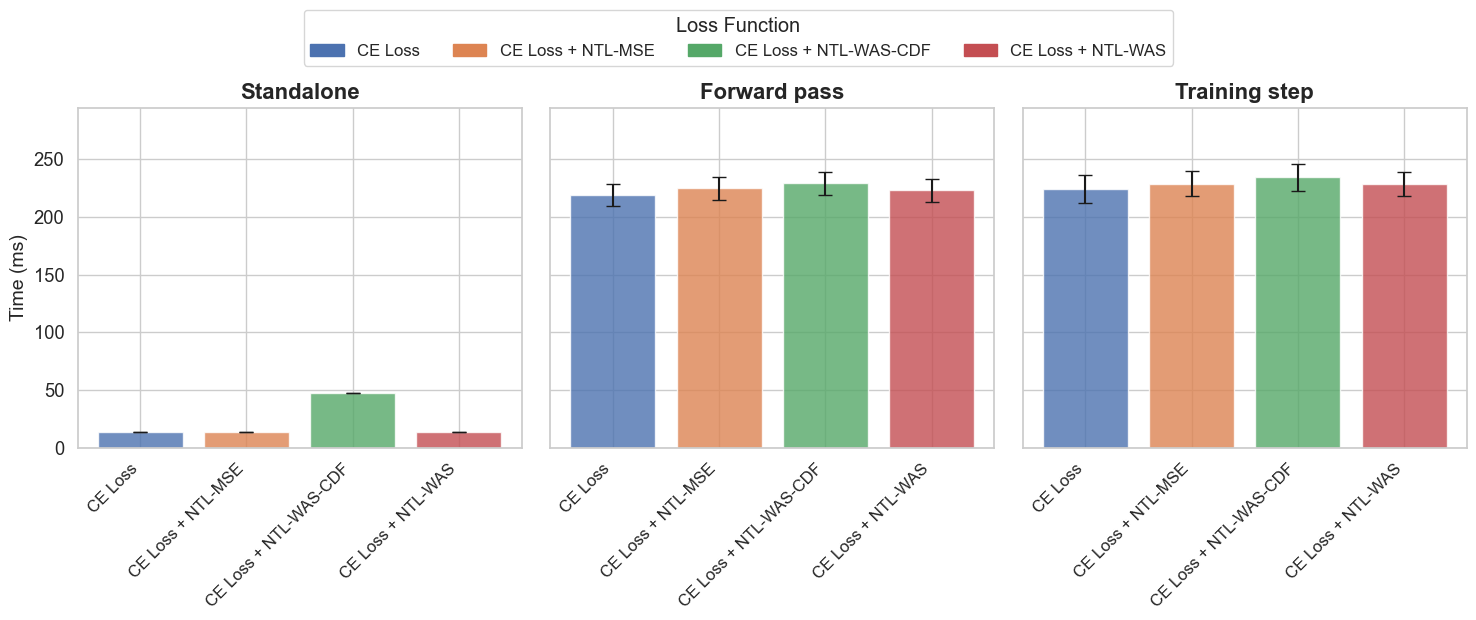

In [46]:
combined_plots(dfs[0.1])

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def combined_plots_y_scaled(df):
    # Set Seaborn style for publication-ready visuals
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

    # Unique benchmarks and loss functions
    benchmarks = df["benchmark"].unique()
    loss_functions = df["Loss"].unique()

    # Define colors using Seaborn palette
    palette = sns.color_palette("deep")
    color_map = {loss: color for loss, color in zip(loss_functions, palette)}

    # Set up the plot with one subplot per benchmark
    fig, axes = plt.subplots(1, len(benchmarks), figsize=(5 * len(benchmarks), 6), sharey=False)

    # Plot for each benchmark
    for i, (benchmark, ax) in enumerate(zip(benchmarks, axes)):
        subset = df[df["benchmark"] == benchmark]
        
        # Bar positions
        x_positions = np.arange(len(subset))

        # Plot bars with error bars, using different colors for each loss function
        for j, (loss, mean_time, error) in enumerate(zip(subset["Loss"], subset["mean_time"], subset["error"])):
            ax.bar(x_positions[j], mean_time * 1_000,  # Scale mean_time to ms
                   yerr=error * 1_000,  # Scale error to ms
                   capsize=5, color=color_map[loss], alpha=0.8, label=loss if i == 0 else "")

        # Customize each subplot
        ax.set_xticks(x_positions)
        ax.set_xticklabels(subset["Loss"], rotation=45, ha="right", fontsize=12)
        ax.set_title(benchmark, fontsize=16, weight="bold")
        ax.set_ylabel("Time (ms)", fontsize=14)

        # Dynamic y-axis scaling for each subplot
        max_runtime = (subset["mean_time"] + subset["error"]).max() * 1_000
        ax.set_ylim(0, max_runtime * 1.2)  # Add 20% buffer above the tallest bar

    # Add a single legend outside the plot
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[loss]) for loss in loss_functions]
    fig.legend(handles, loss_functions, title="Loss Function", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=12)

    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make room for the legend
    plt.savefig("combined_benchmark_plots.png", dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()

# Example usage with a DataFrame `df`
# combined_plots(df)


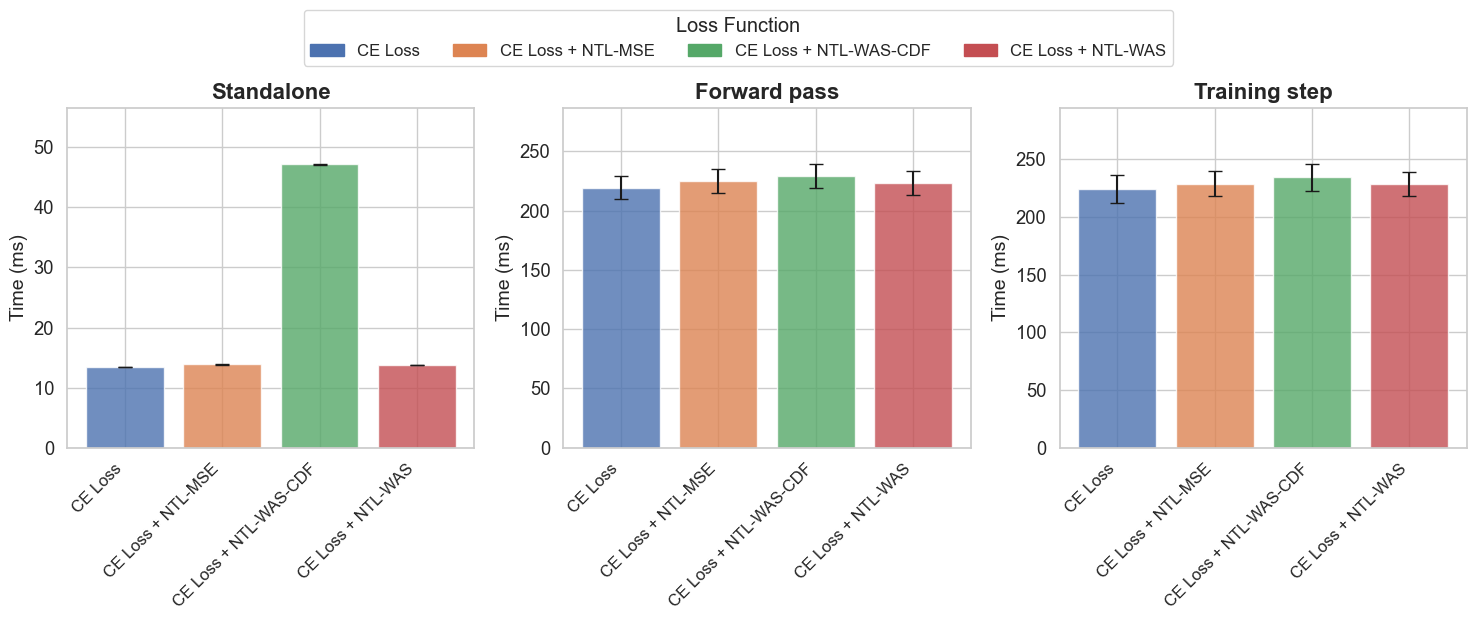

In [48]:
combined_plots_y_scaled(dfs[0.1])

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_relative_speedup(df):
    # Set Seaborn style for publication-ready visuals
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

    # Unique benchmarks and loss functions
    benchmarks = df["benchmark"].unique()
    loss_functions = df["Loss"].unique()

    # Define colors using Seaborn palette
    palette = sns.color_palette("deep")
    color_map = {loss: color for loss, color in zip(loss_functions, palette)}

    # Set up the plot with one subplot per benchmark
    fig, axes = plt.subplots(1, len(benchmarks), figsize=(5 * len(benchmarks), 6), sharey=False)

    # Calculate relative speedup for each benchmark
    for i, (benchmark, ax) in enumerate(zip(benchmarks, axes)):
        subset = df[df["benchmark"] == benchmark].copy()  # Use .copy() to avoid SettingWithCopyWarning

        # Extract runtime and error for "CE Loss"
        ce_loss = subset[subset["Loss"] == "CE Loss"]
        if len(ce_loss) > 1:
            # If there are multiple entries, aggregate them
            ce_loss_time = ce_loss["mean_time"].mean()
            ce_loss_error = ce_loss["error"].mean()
        else:
            # Otherwise, use the single entry
            ce_loss_time = ce_loss["mean_time"].values[0]
            ce_loss_error = ce_loss["error"].values[0]

        # Calculate relative speedup: divide all loss times by CE Loss time
        subset.loc[:, "relative_speedup"] = subset["mean_time"] / ce_loss_time

        # Properly propagate error: includes contributions from both subset error and CE Loss error
        subset.loc[:, "relative_error"] = subset["relative_speedup"] * np.sqrt(
            (subset["error"] / subset["mean_time"])**2 + (ce_loss_error / ce_loss_time)**2
        )

        # Bar positions
        x_positions = np.arange(len(subset))

        # Plot bars with relative speedup and error bars
        for j, (loss, speedup, error) in enumerate(zip(subset["Loss"], subset["relative_speedup"], subset["relative_error"])):
            ax.bar(x_positions[j], speedup,
                   yerr=error, capsize=5,
                   color=color_map[loss], alpha=0.8, label=loss if i == 0 else "")

        # Customize each subplot
        ax.set_xticks(x_positions)
        ax.set_xticklabels(subset["Loss"], rotation=45, ha="right", fontsize=12)
        ax.set_title(benchmark, fontsize=16, weight="bold")
        ax.set_ylabel("Relative Speedup", fontsize=14)
        ax.set_ylim(0, subset["relative_speedup"].max() * 1.2)  # Dynamic y-axis scaling

        # Add horizontal line at speedup = 1 for reference
        ax.axhline(1, color="gray", linestyle="--", linewidth=1)

    # Add a single legend outside the plot
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[loss]) for loss in loss_functions]
    fig.legend(handles, loss_functions, title="Loss Function", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=12)

    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make room for the legend
    plt.savefig("relative_speedup_plots.png", dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()


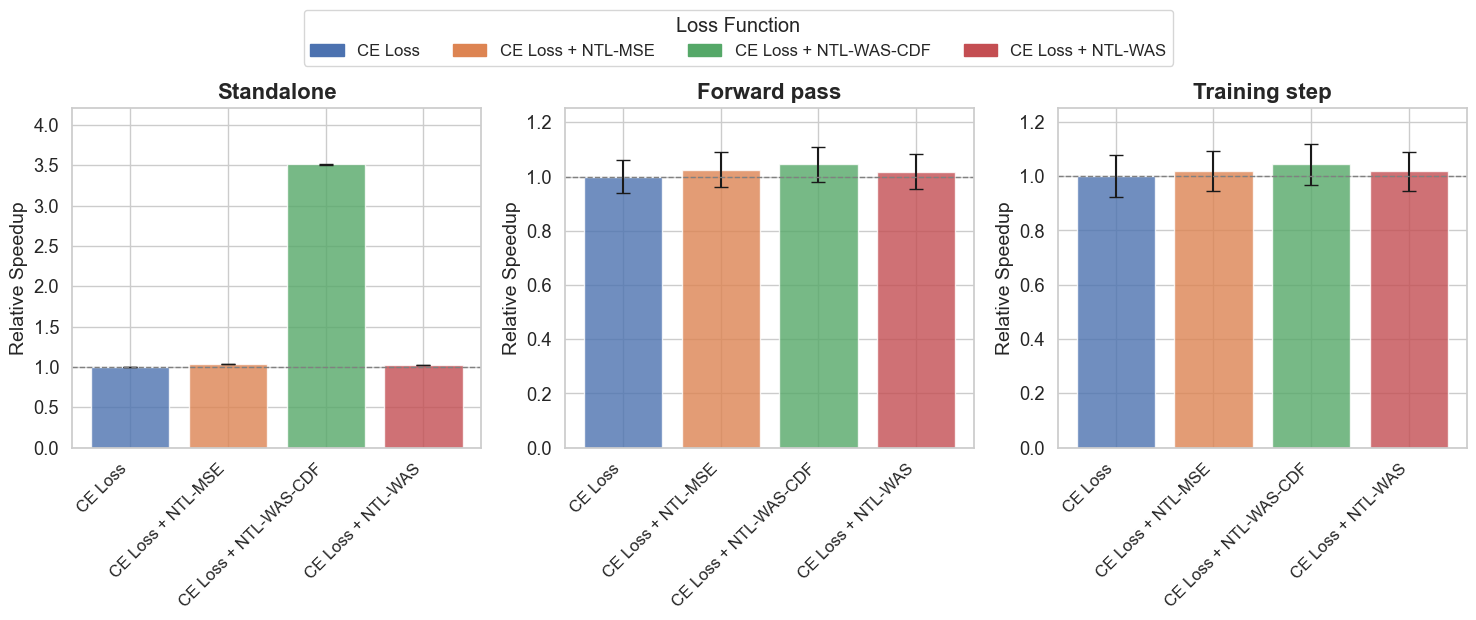

In [52]:
plot_relative_speedup(dfs[0.1])

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def separate_plots(df):
    # Set Seaborn style for publication-ready visuals
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
    
    # Unique benchmarks and loss functions
    benchmarks = df["benchmark"].unique()
    loss_functions = df["Loss"].unique()
    
    # Seaborn color palette
    palette = sns.color_palette("deep")
    color_map = {loss: color for loss, color in zip(loss_functions, palette)}
    
    # Plot for each benchmark separately
    for benchmark in benchmarks:
        # Subset the dataframe for the current benchmark
        subset = df[df["benchmark"] == benchmark]
        
        # Bar positions
        x_positions = np.arange(len(subset))
        
        # Calculate the maximum value for the buffer zone
        max_runtime = (subset["mean_time"] + subset["error"]).max() * 1_000  # Add error to find the tallest bar
        
        # Create the plot
        plt.figure(figsize=(10, 8))
        for j, (loss, mean_time, error) in enumerate(zip(subset["Loss"], subset["mean_time"], subset["error"])):
            plt.bar(x_positions[j], mean_time * 1_000,  # Scale mean_time to milliseconds
                    yerr=error * 1_000,  # Scale error to milliseconds
                    capsize=5, color=color_map[loss], alpha=0.8, label=loss)
        
        # Customize plot
        plt.xticks(x_positions, subset["Loss"], rotation=45, ha="right", fontsize=12)
        plt.title(f"Benchmark: {benchmark}", fontsize=18, weight="bold")
        plt.xlabel("Loss Function", fontsize=14)
        plt.ylabel("Time (ms)", fontsize=14)
        plt.yticks(fontsize=12)
        
        # Adjust y-axis limit to create a buffer zone
        plt.ylim(0, max_runtime * 1.)  # Add 20% buffer above the tallest bar
        
        # Add legend (outside the loop to avoid repetition)
        handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[loss]) for loss in loss_functions]
        plt.legend(handles, loss_functions, title="Loss Function", fontsize=12, loc="upper left")
        
        # Save the plot as a high-resolution image
        plt.tight_layout()
        plt.savefig(f"benchmark_{benchmark.replace(' ', '_')}.png", dpi=300)
        
        # Show the plot
        plt.show()


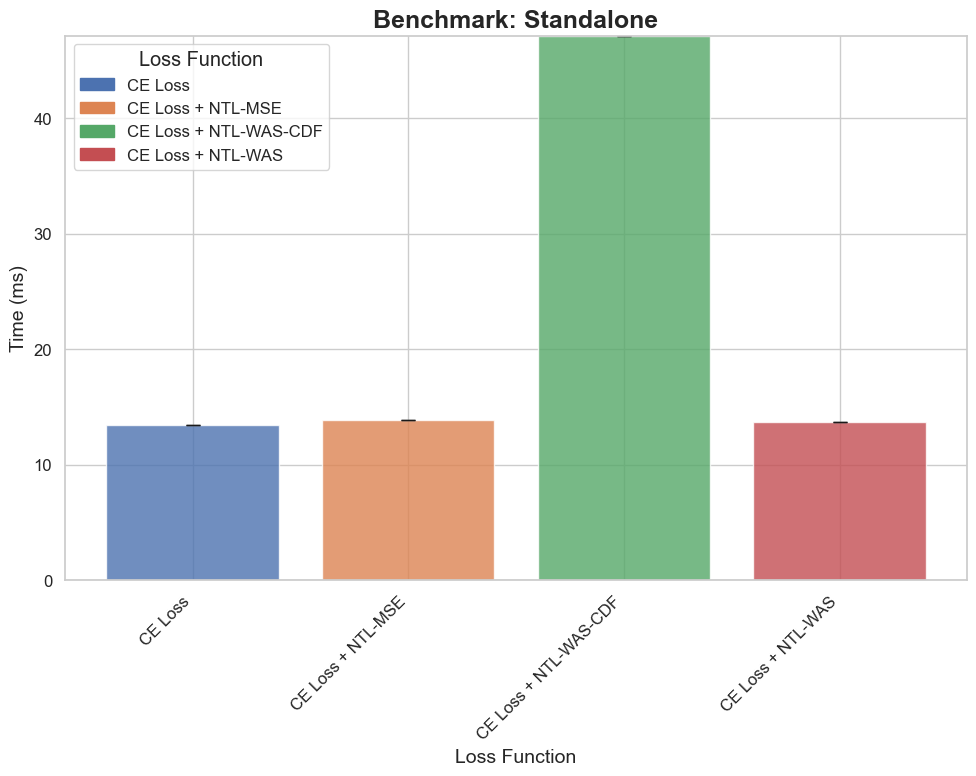

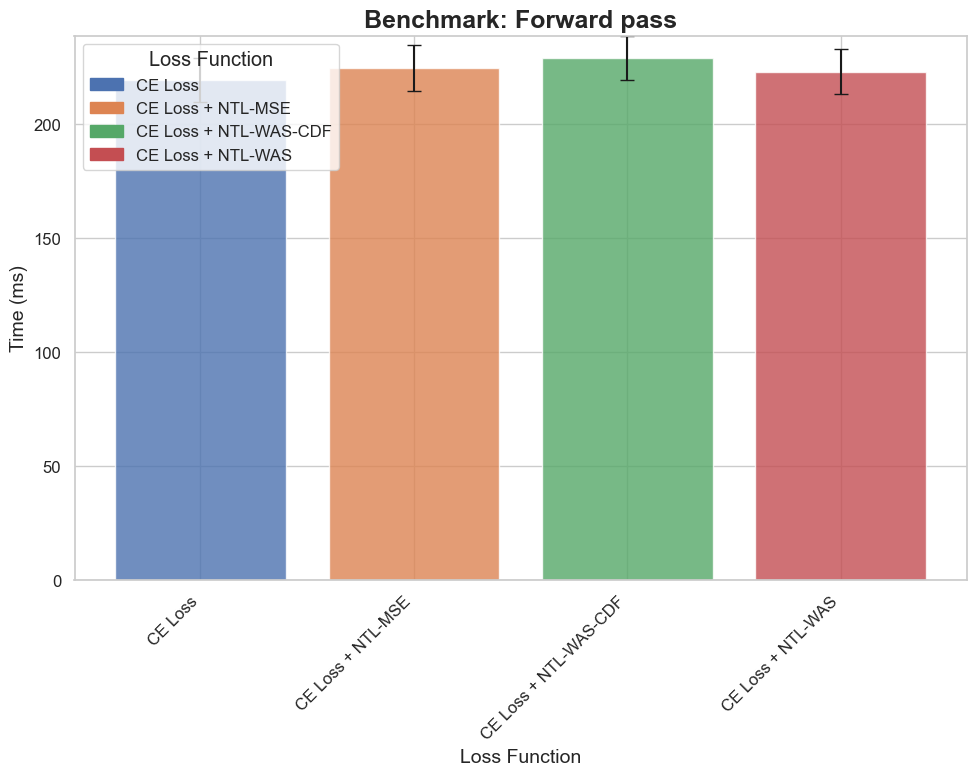

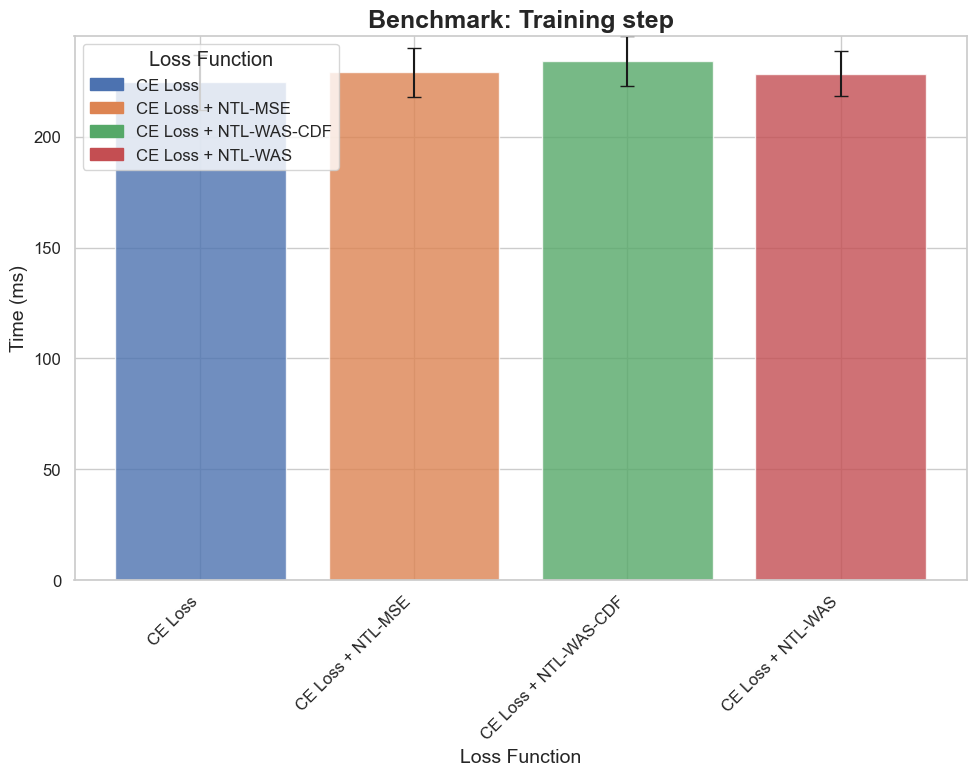

In [16]:
separate_plots(dfs[0.1])

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_number_share(data):
    # Set Seaborn style
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
    
    # Extract unique benchmarks
    benchmarks = data[0.1]["benchmark"].unique()
    loss_functions = data[0.1]["Loss"].unique()

    # Define Seaborn color palette for different losses
    palette = sns.color_palette("deep")  # Seaborn default colors

    loss_colors = {}
    for i, loss in enumerate(loss_functions):
        loss_colors[loss] = palette[i]
    
    # Iterate over each benchmark to create a plot
    for benchmark in benchmarks:
        plt.figure(figsize=(10, 8))

        x_positions = np.arange(len(data))  # One position for each number share
        
        # Bar width
        bar_width = 0.2
        
        # Initialize a variable to find the maximum y value
        max_runtime = 0

        # Loop through each loss to plot bars
        for i, loss in enumerate(loss_functions):
            mean_times = []
            std_devs = []
            for portion, df in data.items():
                # Filter data for the current loss and benchmark
                subset = df[(df['benchmark'] == benchmark) & (df['Loss'] == loss)]
                mean_time_ms = subset['mean_time'].values[0] * 1_000  # Scale to ms
                error_ms = subset['error'].values[0] * 1_000          # Scale error to ms
                mean_times.append(mean_time_ms)
                std_devs.append(error_ms)
                
                # Update max runtime for scaling the y-axis
                max_runtime = max(max_runtime, mean_time_ms + error_ms)
            
            # Plot the bars with error bars (standard deviation)
            plt.bar(x_positions + i * bar_width, mean_times, 
                    yerr=std_devs,  # Add error bars
                    capsize=4,      # Add caps on error bars
                    width=bar_width, color=loss_colors[loss], label=loss, alpha=0.9)
        
        # Add buffer zone above the tallest bar
        plt.ylim(0, max_runtime * 1.4)  # Add 20% buffer

        # Configure plot
        plt.title(f"Runtime for Benchmark: {benchmark}", fontsize=18, weight='bold')
        plt.xlabel("Number Share", fontsize=14)
        plt.ylabel("Mean Runtime (ms)", fontsize=14)
        plt.xticks(ticks=x_positions + bar_width * (len(loss_functions)-1) / 2, 
                   labels=[str(k) for k in data.keys()], fontsize=12)
        plt.yticks(fontsize=12)

        # Add legend
        handles = [plt.Rectangle((0, 0), 1, 1, color=loss_colors[loss]) for loss in loss_functions]
        plt.legend(handles, loss_functions, title="Loss Function", fontsize=12, loc="upper left")
        
        # Tweak grid and layout
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout to fit the legend
        
        # Save plot as high-resolution image for a paper
        plt.savefig(f"runtime_benchmark_{benchmark.replace(' ', '_')}.png", dpi=300, bbox_inches="tight")
        
        # Show the plot
        plt.show()


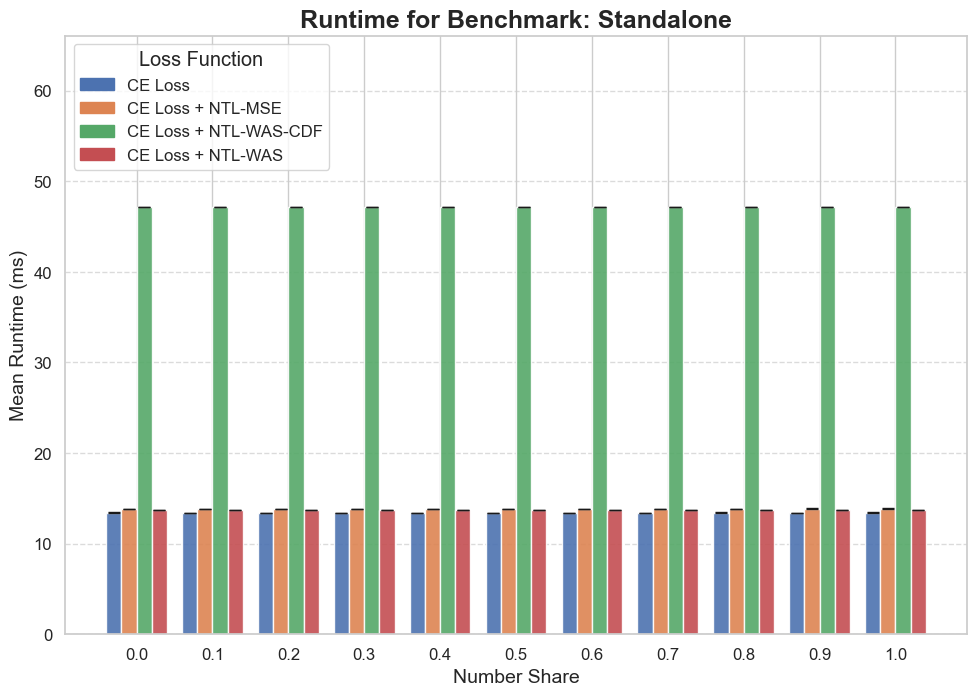

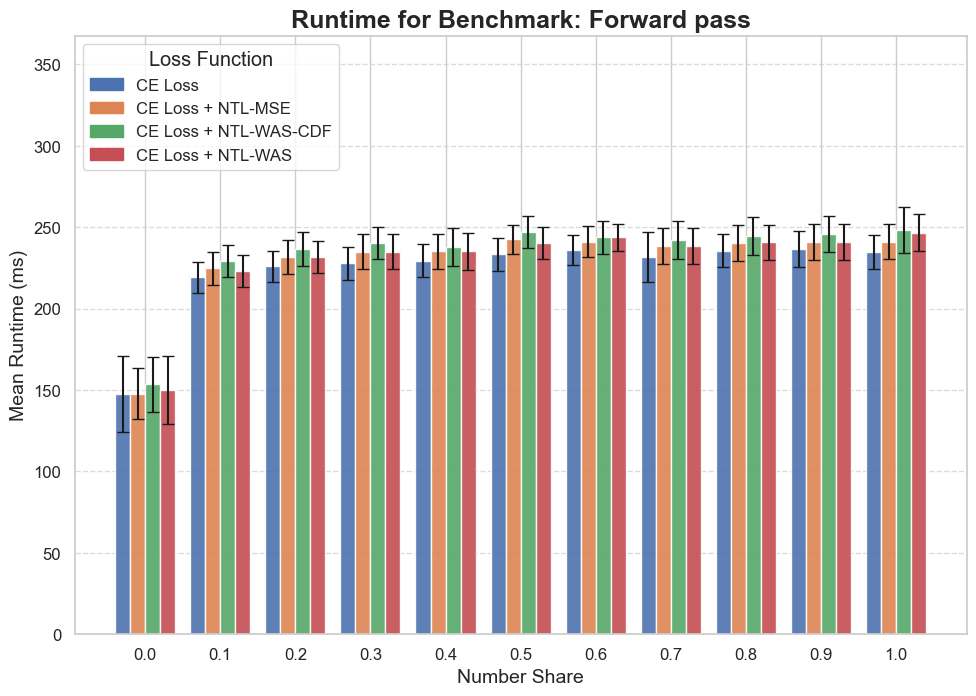

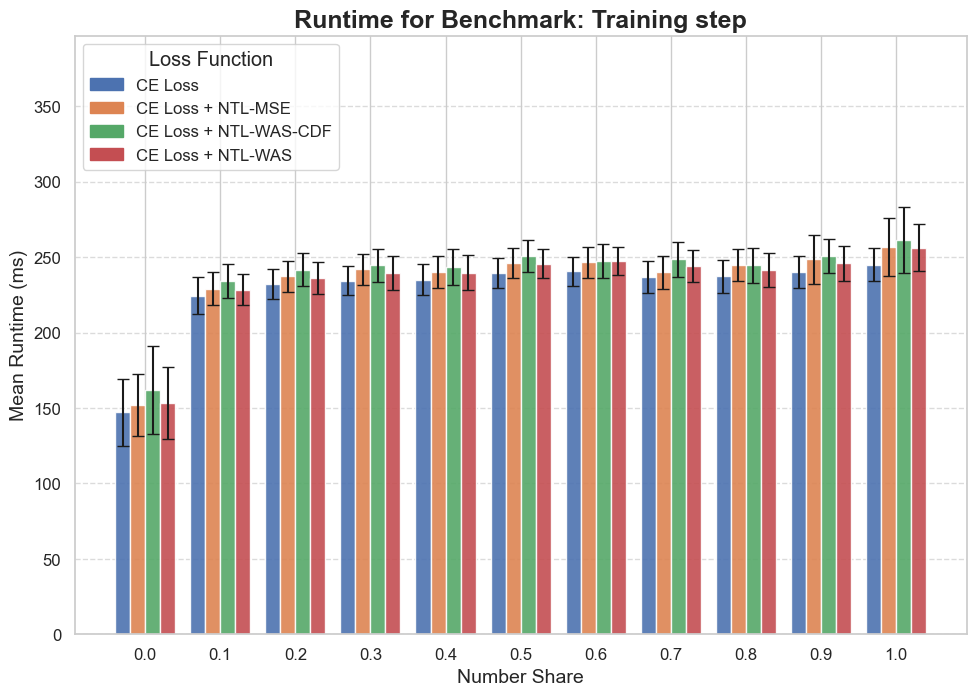

In [26]:
plot_number_share(dfs)